<a href="https://colab.research.google.com/github/remisoulignac/scm_optim_problems/blob/main/SC1X_Python_Samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Week 8: Inventory III - Multi-period Inventory Models - MM PP6 - New Day Electronics
You have been hired by New Day Electronics Inc. (NDE), an original device manufacturer (ODM) of low-end smart phones, based in China. Each smart phone is powered by an application processor (AP), which serves as the 'brain' that makes the phone 'smart'. Although NDE assembles the phones, it does not make the APs. Instead, all the APs are procured from a microchip manufacturer based in Vietnam. The APs are produced in a facility that is in high demand, which means there is usually a long leadtime for the delivery of the products after the order is placed.

You are in charge of managing the inventory for the APs. You have decided to use an (s,Q) inventory policy. NDE's annual demand for APs item is normally distributed with a mean of 2,500 units. Based on the RMSE, you know that the standard deviation of the AP demand is 224 units per year. Each AP costs you \$10. Placing an order is extremely cheap: you calculate it only costs you \$5 to place each order.  The lead-time is constant and equal to 10 weeks. (For the purpose of this problem, assume there are 52 week in a year.)  The holding charge is 25% annually.

1.1) What is the economic order quantity, Q*, for the APs? Round to the nearest integer.

1.2) In case of a stock out of APs, there is a penalty of $6 per unit short per year. What is the reorder point, s, for your current policy? Round to the nearest integer. What is the Expected Units Short per Cycle ?

Algorithm :

1) We find EOQ with the classical formula 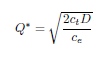

2)  We find k such as  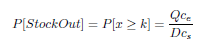

3) We find the Expected Units Short per Cycle : image.png with G(k) the Unit Normal Loss Function.

In [31]:
import math
from scipy.stats import norm

# Basic Continous Inventory Management. Checking theory and simulation


WEEKS_PER_YEAR=52

µD=2500 #mean demand : units/year
σD=224 #stddev demand : units/year
c=10  #cost : $/unit
ct=5  #order cost : $/order
µL=10/WEEKS_PER_YEAR #mean lead time : year
h=0.25 #holding cost : $/$/year capital costs (opportunity cost of alternative investment) and non-capital holding costs : storage cost, service costs (insurance,taxes), risk costs (lost, stolen, damaged, obsolete)
cs=6 #$/per unit short

#Basic optimization for Multiperiod Inventory Problem
#Economic Order Quantity
eoq=math.sqrt(2*µD*ct/(h*c))
#Safety Stock
POptimalCostStockout = eoq*h*c / (µD * cs)
assert(POptimalCostStockout<1)
k=norm.ppf(1-POptimalCostStockout)
#Demand during leadtime
µDL=µD*µL
σDL=math.sqrt(µL)*σD
#Reorder point
reorder_point=µDL+k*σDL
estimated_stock_out_quantities=σDL*(norm.pdf(k)-k*(1-norm.cdf(k)))
print(f"Order Quantity: {eoq}, Reorder point : {reorder_point}")
print(f"Expected Cycle Service Level : {norm.cdf(k)}, Expected Units Short by Cycle : {estimated_stock_out_quantities}")


Order Quantity: 100.0, Reorder point : 689.8081742353157
Expected Cycle Service Level : 0.9833333333333333, Expected Units Short by Cycle : 0.5878370899002969


In [30]:
# let's simulate the same result
# we construct here a simple monte carlo simulation (see : https://courses.edx.org/assets/courseware/v1/ab0b1e99bf1dfd166fae02fa0523500a/asset-v1:MITx+CTL.SC0x+3T2020+type@asset+block/SC0x_W10L2_DiscreteEventSimulation.pdf) 
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

def sim(demand_per_period, stddev_demand, avg_lead_time, reorder_point, eoq, nb_sim_periods=6000, steps_per_period=10):
  periods=range(nb_sim_periods)
  demands = norm(demand_per_period/steps_per_period, stddev_demand*math.sqrt(1/steps_per_period)).rvs(nb_sim_periods*steps_per_period)
  result = {}
  pipeline_orders= []
  stock_out_cycles=[]
  units_short_per_cycle=[]

  inventory_position = reorder_point+eoq
  inventory_on_hand= inventory_position

  for p in tqdm(periods):
    # for plotting, we remember the position of the inventories 

    for s in range(0, steps_per_period):
      #simulation instant      
      t=p*steps_per_period+s

      # look for the reception of past orders
      for order in list(pipeline_orders):
        if order["expected_delivery_instant"]<=t:
          #the order is processed a little bit later than planned so we rewind to the instant
          #the order should have arrived
          real_ioh=inventory_on_hand+(t-order["expected_delivery_instant"])*demands[t]
          stock_out_cycles.append(1 if real_ioh <0 else 0)
          units_short_per_cycle.append(-min(real_ioh,0))
          inventory_on_hand+=order["size"]
          pipeline_orders.remove(order)

      # we substract the daily demand from our inventories
      inventory_position-=demands[t]
      inventory_on_hand-=demands[t]

      # should we order ? 
      if (inventory_position <= reorder_point): 
        #we should have ordered exactly when inventory_position=reorder_point
        real_reorder_t=t-(reorder_point-inventory_position)/demands[t]
        pipeline_orders.append({"expected_delivery_instant":real_reorder_t+avg_lead_time*steps_per_period, "size":eoq})
        inventory_position=inventory_position+eoq

  result["cycle_service_level"]=(1-np.average(stock_out_cycles))
  result["units_short_per_cycle"]=np.average(units_short_per_cycle)
  return result

results=[]
r=sim(µD/WEEKS_PER_YEAR, σD*math.sqrt(1/WEEKS_PER_YEAR), µL*WEEKS_PER_YEAR,  reorder_point, eoq, 500000, 10)
print("Simulation results")
print(f" Cycle Service Level : {r['cycle_service_level']}")
print(f" Units Short by cycle : {r['units_short_per_cycle']}")

  0%|          | 0/500000 [00:00<?, ?it/s]

Simulation results
 Cycle Service Level : 0.9837714838214947
 Units Short by cycle : 0.5505139864772555
